# Data and libraries import with creation of the new files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm # Library for progress bars
import os
import math

# One-Time Data Preprocessing: Image Generation (Optimized for Speed and Memory)

# Helper function definitions, needed for preprocessing
IMAGE_SIZE = 64

def parse_coords(coord_string):
    """Converts a space-separated string of coordinates into a list of floats."""
    if isinstance(coord_string, str):
        return [float(c) for c in coord_string.strip().split()]
    return []

def rasterize_airfoil(points, image_size=IMAGE_SIZE):
    """Converts a sequence of points into a binary image."""
    if not points or len(points) < 2:
        return np.zeros((image_size, image_size), dtype=np.float32)

    image = np.zeros((image_size, image_size), dtype=np.float32)
    points_arr = np.array(points, dtype=np.float32)

    min_coords = points_arr.min(axis=0)
    max_coords = points_arr.max(axis=0)
    points_arr -= min_coords
    
    scale = max_coords - min_coords
    if np.all(scale == 0): return image
        
    scale_factor = (0.8 * image_size) / max(scale.max(), 1e-6)
    points_arr *= scale_factor
    
    max_coords_scaled = points_arr.max(axis=0)
    offset = (image_size - max_coords_scaled) / 2.0
    points_arr += offset
    
    points_int = points_arr.astype(int)

    for i in range(len(points_int) - 1):
        x1, y1 = points_int[i]; x2, y2 = points_int[i+1]
        dx, dy = abs(x2 - x1), -abs(y2 - y1)
        sx, sy = 1 if x1 < x2 else -1, 1 if y1 < y2 else -1
        err = dx + dy
        while True:
            if 0 <= x1 < image_size and 0 <= y1 < image_size:
                image[image_size - 1 - y1, x1] = 1.0
            if x1 == x2 and y1 == y2: break
            e2 = 2 * err
            if e2 >= dy: err += dy; x1 += sx
            if e2 <= dx: err += dx; y1 += sy
    return image

# --- CONFIGURATION FOR PREPROCESSING ---
original_file = 'DeepLearWing.csv'
NUM_CHUNKS = 1 # You can change this value if there are problems with loading the data (e.g., to 10, 20)
config_file = 'chunk_config.txt'

# --- INTELLIGENT CHUNK MANAGEMENT ---
# Check if the configuration has changed
regenerate_data = False
if not os.path.exists(config_file):
    regenerate_data = True
else:
    with open(config_file, 'r') as f:
        try:
            saved_chunks = int(f.read())
            if saved_chunks != NUM_CHUNKS:
                regenerate_data = True
                print(f"Configuration changed from {saved_chunks} to {NUM_CHUNKS} chunks. Regenerating data.")
        except ValueError:
            regenerate_data = True # Handle corrupted config file

if regenerate_data:
    print("Deleting old chunk files...")
    for i in range(100): # Check for a high number of old chunks
        pkl_file = f'processed_data_chunk_{i}.pkl'
        pt_file = f'processed_images_chunk_{i}.pt'
        if os.path.exists(pkl_file): os.remove(pkl_file)
        if os.path.exists(pt_file): os.remove(pt_file)

# --- ONE-TIME PREPROCESSING SCRIPT with CHUNKING ---
processed_chunk_file_0 = f'processed_data_chunk_0.pkl'
if not os.path.exists(processed_chunk_file_0):
    print(f"Pre-computed chunk files not found. Starting one-time generation process for {NUM_CHUNKS} chunks...")
    try:
        print(f"Loading original file '{original_file}'...")
        df_orig = pd.read_csv(original_file)
        print(f"Original file loaded successfully.")

        chunk_size = math.ceil(len(df_orig) / NUM_CHUNKS)
        
        for i in range(NUM_CHUNKS):
            print(f"\nProcessing and saving chunk {i+1}/{NUM_CHUNKS}...")
            start_idx = i * chunk_size
            end_idx = min((i + 1) * chunk_size, len(df_orig))
            if start_idx >= len(df_orig): continue # In case NUM_CHUNKS is very large
            
            df_chunk = df_orig.iloc[start_idx:end_idx]

            images = np.zeros((len(df_chunk), IMAGE_SIZE, IMAGE_SIZE), dtype=np.float32)
            for j, (original_index, row) in enumerate(tqdm(df_chunk.iterrows(), total=len(df_chunk), desc=f"Rasterizing chunk {i+1}")):
                points = list(zip(parse_coords(row['x_coords']), parse_coords(row['y_coords'])))
                images[j] = rasterize_airfoil(points)
            
            images_tensor = torch.from_numpy(images)
            df_chunk_meta = df_chunk.drop(columns=['x_coords', 'y_coords'])

            df_chunk_meta.to_pickle(f'processed_data_chunk_{i}.pkl')
            torch.save(images_tensor, f'processed_images_chunk_{i}.pt')
            print(f"Chunk {i+1} saved successfully.")

        with open(config_file, 'w') as f:
            f.write(str(NUM_CHUNKS))
        print(f"\nPreprocessing complete. Configuration saved for {NUM_CHUNKS} chunks.")

    except FileNotFoundError:
        print(f"Error: Original file '{original_file}' not found.")
        sys.exit()

# Manual chunk selection and data loading

In [2]:
# --- CHOOSE WHICH CHUNK TO LOAD ---
# Change this value from 0 to NUM_CHUNKS-1 to select a different part of the dataset
CHUNK_TO_LOAD = 0 

if CHUNK_TO_LOAD >= NUM_CHUNKS:
    print(f"Error: CHUNK_TO_LOAD is set to {CHUNK_TO_LOAD}, but only {NUM_CHUNKS} chunks are available (0 to {NUM_CHUNKS-1}).")
    sys.exit()

print(f"\nLoading pre-processed chunk {CHUNK_TO_LOAD} into memory...")
try:
    df = pd.read_pickle(f'processed_data_chunk_{CHUNK_TO_LOAD}.pkl')
    images_tensor_chunk = torch.load(f'processed_images_chunk_{CHUNK_TO_LOAD}.pt')
    # Store images directly in the dataframe for easy access.
    # This is memory-intensive but required for the current Dataset implementation.
    # For very large chunks, this might need further optimization (e.g., passing tensors to Dataset).
    df['image'] = list(images_tensor_chunk.numpy())
    print(f"Chunk {CHUNK_TO_LOAD} loaded successfully. Using {len(df)} samples for this session.")
except FileNotFoundError:
    print(f"Error: Chunk file for chunk {CHUNK_TO_LOAD} not found. Please run the preprocessing step first.")
    sys.exit()


Loading pre-processed chunk 0 into memory...
Chunk 0 loaded successfully. Using 819191 samples for this session.


# Outputing 3 random airfoils and their data

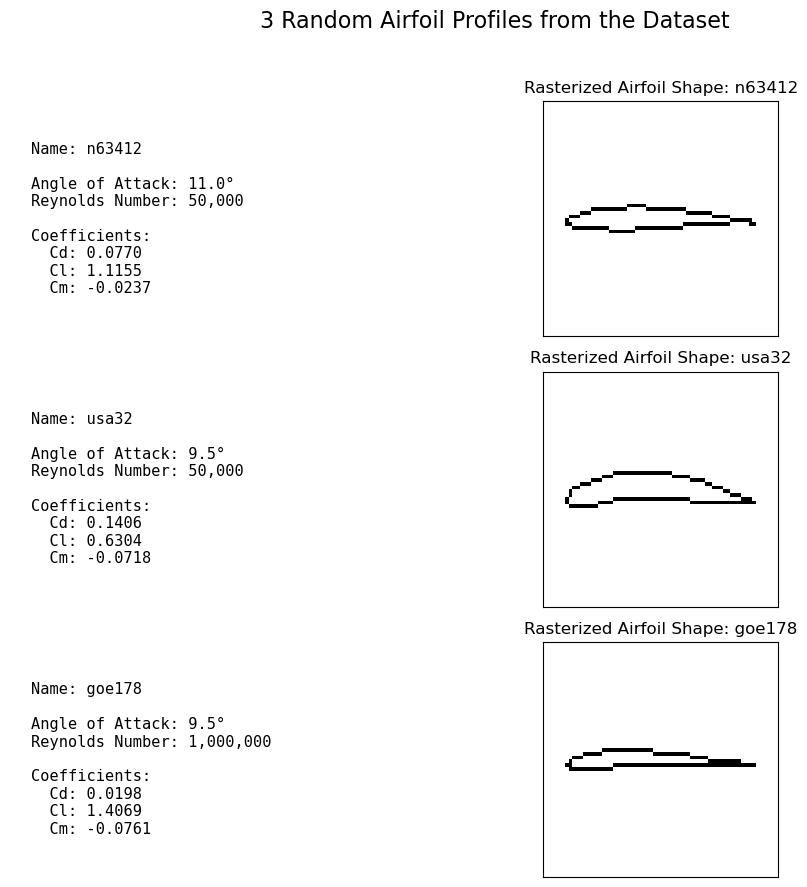

In [3]:
random_airfoils = df.sample(n=3)

fig, axes = plt.subplots(3, 2, figsize=(10, 9), gridspec_kw={'width_ratios': [1, 1.5]})
fig.suptitle('3 Random Airfoil Profiles from the Dataset', fontsize=16)

for i, (index, row) in enumerate(random_airfoils.iterrows()):
    ax_text = axes[i, 0]
    ax_text.axis('off')
    info_text = (f"Name: {row['name']}\n\nAngle of Attack: {row['angle']}°\n"
                 f"Reynolds Number: {row['reynolds']:,.0f}\n\nCoefficients:\n"
                 f"  Cd: {row['cd']:.4f}\n  Cl: {row['cl']:.4f}\n  Cm: {row['cm']:.4f}")
    ax_text.text(0.05, 0.5, info_text, transform=ax_text.transAxes, fontsize=11, verticalalignment='center', family='monospace')
    
    ax_plot = axes[i, 1]
    # Displaying the processed image now
    ax_plot.imshow(row['image'], cmap='gray_r')
    ax_plot.set_title(f'Rasterized Airfoil Shape: {row["name"]}')
    ax_plot.set_xticks([])
    ax_plot.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

# Data Preprocessing for the CNN Model

In [4]:
print("\nStarting Data Preprocessing for CNN Model")

features_scalar = ['angle', 'reynolds']
all_targets = ['cl', 'cd', 'cm']

# Data splitting logic is now applied to the loaded chunk
airfoil_names = df['name'].unique()
train_names, test_names = train_test_split(airfoil_names, test_size=0.3, random_state=42)
val_names, test_names = train_test_split(test_names, test_size=0.5, random_state=42)

train_df = df[df['name'].isin(train_names)].copy()
val_df = df[df['name'].isin(val_names)].copy()
test_df = df[df['name'].isin(test_names)].copy()

print(f"Data split into: \n- Train: {len(train_df)} samples\n- Validation: {len(val_df)} samples\n- Test: {len(test_df)} samples")

# Normalization logic
scalar_feature_scaler = MinMaxScaler()
target_scalers = {target: MinMaxScaler() for target in all_targets}

train_df.loc[:, features_scalar] = scalar_feature_scaler.fit_transform(train_df[features_scalar])
val_df.loc[:, features_scalar] = scalar_feature_scaler.transform(val_df[features_scalar])
test_df.loc[:, features_scalar] = scalar_feature_scaler.transform(test_df[features_scalar])

for target in all_targets:
    train_df.loc[:, target] = target_scalers[target].fit_transform(train_df[[target]])
    val_df.loc[:, target] = target_scalers[target].transform(val_df[[target]])
    test_df.loc[:, target] = target_scalers[target].transform(test_df[[target]])

print("Scalar features and targets have been normalized.")


Starting Data Preprocessing for CNN Model
Data split into: 
- Train: 570812 samples
- Validation: 125457 samples
- Test: 122922 samples
Scalar features and targets have been normalized.


C:\Users\skrze\AppData\Local\Temp\ipykernel_26012\445573580.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.15789474 0.15789474 0.15789474 ... 0.05263158 0.05263158 0.05263158]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[:, features_scalar] = scalar_feature_scaler.fit_transform(train_df[features_scalar])
C:\Users\skrze\AppData\Local\Temp\ipykernel_26012\445573580.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.15789474 0.15789474 0.15789474 ... 0.05263158 0.05263158 0.05263158]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  val_df.loc[:, features_scalar] = scalar_feature_scaler.transform(val_df[features_scalar])
C:\Users\skrze\AppData\Local\Temp\ipykernel_26012\445573580.py:23: FutureWarning: Setting an item of incompatible dtyp

# PyTorch Dataset and DataLoader for CNN

In [5]:
class AirfoilDatasetCNN(Dataset):
    """Dataset is memory-efficient as it retrieves single images from the pre-loaded dataframe."""
    def __init__(self, dataframe, target_name):
        self.dataframe = dataframe.reset_index(drop=True)
        self.target_name = target_name
        # NOTE: We only store lightweight features. Images are accessed from the dataframe.
        self.other_features = torch.tensor(self.dataframe[features_scalar].values, dtype=torch.float32)
        self.targets = torch.tensor(self.dataframe[[self.target_name]].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Retrieve the pre-loaded image for the specific index
        image = self.dataframe.loc[idx, 'image']
        image_tensor = torch.from_numpy(image).float().unsqueeze(0) # Add channel dimension
        
        # Retrieve pre-converted data, which is very fast
        return image_tensor, self.other_features[idx], self.targets[idx]

# CNN model

In [6]:
class AirfoilCNNRegressor(nn.Module):
    """CNN model modified to predict a single output value."""
    def __init__(self, image_size=IMAGE_SIZE, fc_hidden_dim=128, output_dim=1, other_features_dim=2, dropout_prob=0.3):
        super(AirfoilCNNRegressor, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.BatchNorm2d(64)
        )
        
        self.flattened_size = 64 * (image_size // 8) * (image_size // 8)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size + other_features_dim, fc_hidden_dim), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(fc_hidden_dim, fc_hidden_dim // 2), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(fc_hidden_dim // 2, output_dim)
        )

    def forward(self, image_data, other_features):
        x = self.conv_layers(image_data)
        x = x.view(x.size(0), -1)
        combined_features = torch.cat((x, other_features), dim=1)
        predictions = self.fc_layers(combined_features)
        return predictions


# Model training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
BATCH_SIZE = 128
NUM_EPOCHS = 10 
all_losses = {}
trained_models = {}

for target_name in all_targets:
    print(f"\n--- Starting training for target: {target_name.upper()} ---")

    train_dataset = AirfoilDatasetCNN(train_df, target_name=target_name)
    val_dataset = AirfoilDatasetCNN(val_df, target_name=target_name)
    # Set num_workers=0 and pin_memory=False for optimal performance in this specific case
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

    model = AirfoilCNNRegressor(output_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        model.train()
        # Wrap train_loader with tqdm for a progress bar
        pbar = tqdm(train_loader, desc=f"Training {target_name.upper()}", leave=False)
        running_train_loss = 0.0
        for images, others, targets_batch in pbar:
            images, others, targets_batch = images.to(device), others.to(device), targets_batch.to(device)
            predictions = model(images, others)
            loss = criterion(predictions, targets_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            # Update the progress bar with the current loss
            pbar.set_postfix(loss=loss.item())

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, others, targets_batch in val_loader:
                images, others, targets_batch = images.to(device), others.to(device), targets_batch.to(device)
                predictions = model(images, others)
                loss = criterion(predictions, targets_batch)
                running_val_loss += loss.item()
        
        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_val_loss = running_val_loss / len(val_loader)
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Summary -> Train Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

    all_losses[target_name] = {'train': train_losses, 'val': val_losses}
    trained_models[target_name] = model
    torch.save(model.state_dict(), f'saved_model_cnn_{target_name}.pth')
    print(f"--- Training for {target_name.upper()} finished. Model saved. ---")

Using device: cuda

--- Starting training for target: CL ---

Epoch 1/10


Epoch [1/10] Summary -> Train Loss: 0.014835, Validation Loss: 0.008969

Epoch 2/10


Epoch [2/10] Summary -> Train Loss: 0.005053, Validation Loss: 0.006484

Epoch 3/10


Epoch [3/10] Summary -> Train Loss: 0.003209, Validation Loss: 0.004896

Epoch 4/10


Epoch [4/10] Summary -> Train Loss: 0.003208, Validation Loss: 0.004858

Epoch 5/10


Epoch [5/10] Summary -> Train Loss: 0.003527, Validation Loss: 0.005278

Epoch 6/10


Epoch [6/10] Summary -> Train Loss: 0.002605, Validation Loss: 0.004246

Epoch 7/10


Epoch [7/10] Summary -> Train Loss: 0.002221, Validation Loss: 0.004893

Epoch 8/10


Epoch [8/10] Summary -> Train Loss: 0.002065, Validation Loss: 0.003508

Epoch 9/10


Epoch [9/10] Summary -> Train Loss: 0.002019, Validation Loss: 0.003198

Epoch 10/10


Epoch [10/10] Summary -> Train Loss: 0.001983, Validation Loss: 0.003279
--- Training for CL finished. Model saved. ---

--- Starting training for target: CD ---

Epoch 1/10


Epoch [1/10] Summary -> Train Loss: 0.006190, Validation Loss: 0.005671

Epoch 2/10


Epoch [2/10] Summary -> Train Loss: 0.005028, Validation Loss: 0.004966

Epoch 3/10


Epoch [3/10] Summary -> Train Loss: 0.004104, Validation Loss: 0.005013

Epoch 4/10


Epoch [4/10] Summary -> Train Loss: 0.003021, Validation Loss: 0.002666

Epoch 5/10


Epoch [5/10] Summary -> Train Loss: 0.002172, Validation Loss: 0.002218

Epoch 6/10


Epoch [6/10] Summary -> Train Loss: 0.001895, Validation Loss: 0.002328

Epoch 7/10


Epoch [7/10] Summary -> Train Loss: 0.001780, Validation Loss: 0.002168

Epoch 8/10


Epoch [8/10] Summary -> Train Loss: 0.001564, Validation Loss: 0.002156

Epoch 9/10


Epoch [9/10] Summary -> Train Loss: 0.001519, Validation Loss: 0.002340

Epoch 10/10


Epoch [10/10] Summary -> Train Loss: 0.001482, Validation Loss: 0.002052
--- Training for CD finished. Model saved. ---

--- Starting training for target: CM ---

Epoch 1/10


Epoch [1/10] Summary -> Train Loss: 0.005468, Validation Loss: 0.003545

Epoch 2/10


Epoch [2/10] Summary -> Train Loss: 0.003093, Validation Loss: 0.003842

Epoch 3/10


Epoch [3/10] Summary -> Train Loss: 0.002832, Validation Loss: 0.003233

Epoch 4/10


Epoch [4/10] Summary -> Train Loss: 0.002597, Validation Loss: 0.003182

Epoch 5/10


Epoch [5/10] Summary -> Train Loss: 0.002496, Validation Loss: 0.003098

Epoch 6/10


Epoch [6/10] Summary -> Train Loss: 0.002426, Validation Loss: 0.003075

Epoch 7/10


Epoch [7/10] Summary -> Train Loss: 0.002369, Validation Loss: 0.002769

Epoch 8/10


Epoch [8/10] Summary -> Train Loss: 0.002200, Validation Loss: 0.002854

Epoch 9/10


Epoch [9/10] Summary -> Train Loss: 0.001942, Validation Loss: 0.002326

Epoch 10/10


Epoch [10/10] Summary -> Train Loss: 0.001837, Validation Loss: 0.002300
--- Training for CM finished. Model saved. ---


# Evaluating model on 10 random airfoils

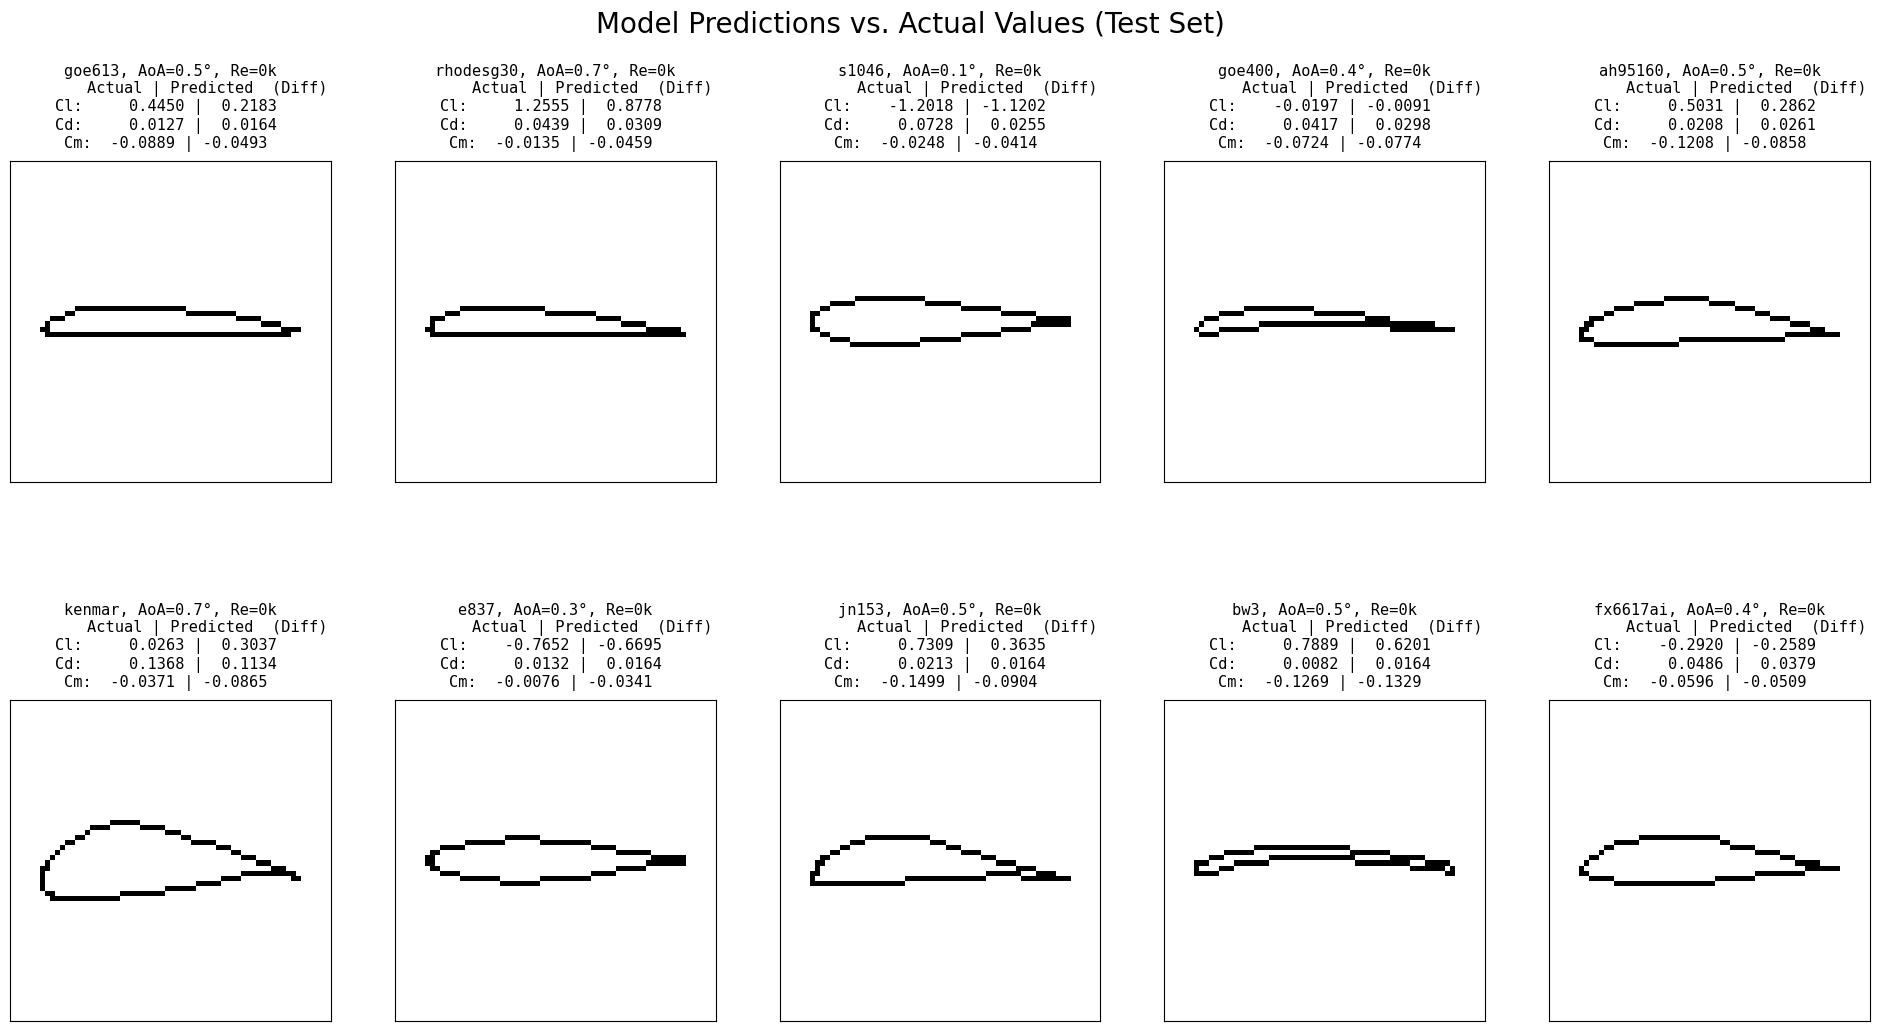

In [15]:
# Set models to evaluation mode
for model in trained_models.values():
    model.eval()


# To evaluate, we take a random sample from the test dataframe directly
eval_samples = test_df.sample(n=10)
# Create a temporary dataset and loader for these samples
eval_dataset = AirfoilDatasetCNN(eval_samples, target_name='cl') # target_name is just a placeholder
eval_loader = DataLoader(eval_dataset, batch_size=10, shuffle=False)

images, others, _ = next(iter(eval_loader))
images, others = images.to(device), others.to(device)

# Collecting predictions from each model
all_predictions = {}
with torch.no_grad():
    for target_name, model in trained_models.items():
        predictions_normalized = model(images, others)
        predictions_real = target_scalers[target_name].inverse_transform(predictions_normalized.cpu().numpy())
        all_predictions[target_name] = predictions_real

# Create a 2x5 grid for plotting
fig, axes = plt.subplots(2, 5, figsize=(24, 12))
axes = axes.flatten()

fig.suptitle('Model Predictions vs. Actual Values (Test Set)', fontsize=20)

for i in range(len(eval_samples)):
    ax = axes[i]
    orig_row = eval_samples.iloc[i]
    
    image_to_plot = orig_row['image']
    ax.imshow(image_to_plot, cmap='gray_r')
    
    pred_cl = all_predictions['cl'][i][0]
    pred_cd = all_predictions['cd'][i][0]
    pred_cm = all_predictions['cm'][i][0]
    
    # We need to get the original unnormalized values for comparison
    true_cl = target_scalers['cl'].inverse_transform(orig_row[['cl']].values.reshape(1, -1))[0,0]
    true_cd = target_scalers['cd'].inverse_transform(orig_row[['cd']].values.reshape(1, -1))[0,0]
    true_cm = target_scalers['cm'].inverse_transform(orig_row[['cm']].values.reshape(1, -1))[0,0]
    
    # Construct the title with the differences
    title_text = (
        f"{orig_row['name']}, AoA={orig_row['angle']:.1f}°, Re={int(orig_row['reynolds']/1000)}k\n"
        f"        Actual | Predicted  (Diff)\n"
        f"Cl:    {true_cl: >7.4f} | {pred_cl: >7.4f} \n"
        f"Cd:    {true_cd: >7.4f} | {pred_cd: >7.4f} \n"
        f"Cm:  {true_cm: >7.4f} | {pred_cm: >7.4f} "
    )
    ax.set_title(title_text, fontsize=11, family='monospace', pad=10) # Increased font size
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(len(eval_samples), len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent title overlap
plt.subplots_adjust(hspace=0.4) # Increased vertical space between rows
plt.show()

# Showing training and validation loss based on CNN model

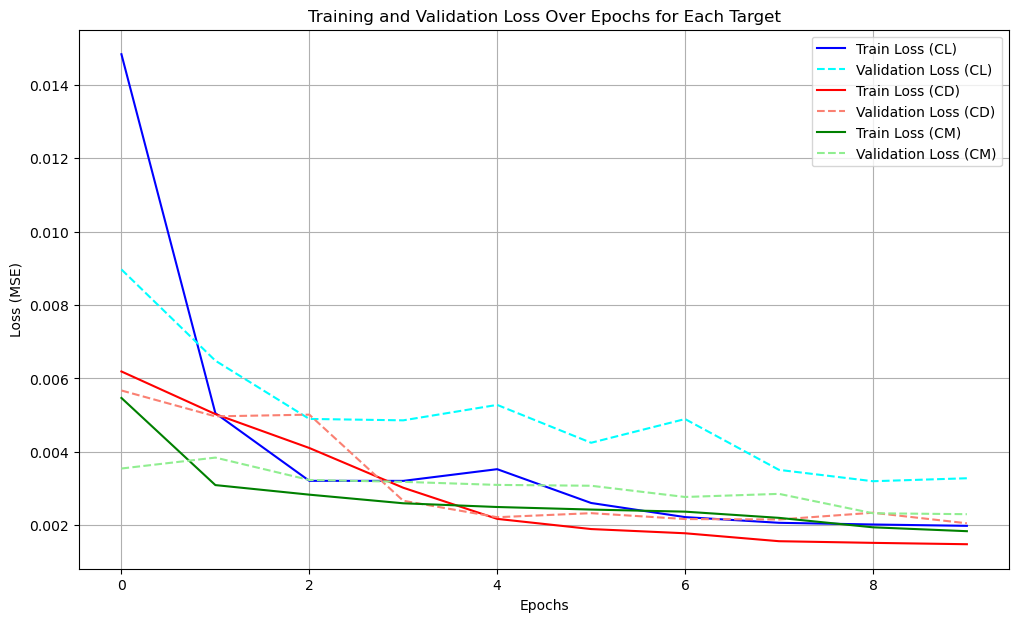

In [10]:
plt.figure(figsize=(12, 7))
colors = {'cl': ('blue', 'cyan'), 'cd': ('red', 'salmon'), 'cm': ('green', 'lightgreen')}

for target_name, losses in all_losses.items():
    plt.plot(losses['train'], label=f'Train Loss ({target_name.upper()})', color=colors[target_name][0])
    plt.plot(losses['val'], label=f'Validation Loss ({target_name.upper()})', color=colors[target_name][1], linestyle='--')

plt.title('Training and Validation Loss Over Epochs for Each Target')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()